In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd

import numpy as np

from dcgan.components.generator import Generator
from dcgan.components.discriminator import Discriminator

In [2]:
def fisher(likelihood, params):
    """
    Funny ref link:
    https://discuss.pytorch.org/t/implementation-of-elastic-weight-consolidation-fisher-information-matrix/9309/3 
    """

    grad1 = autograd.grad(likelihood, params, create_graph=True)
    fisher = []
    for g in grad1:
        fisher.append((g**2).sum()) 

    return fisher


# def loss_adapt(y_model, y_true, model):
#     return nn.BCELoss(y_model, y_true) + regWeight*Fisher(output, gen_param)

In [3]:
generator = Generator()
discriminator = Discriminator()

generator.load_state_dict(torch.load('models/epoch145_gen.pth'))
discriminator.load_state_dict(torch.load('models/epoch145_dis.pth'))

<All keys matched successfully>

In [4]:
batch_size = 256
latent_size = 512
regWeight = 10
criterion = nn.BCELoss()

noise = torch.randn(batch_size, latent_size)
output = discriminator(generator(noise)).view(-1)
real_label=torch.full((batch_size, ), 1, dtype=torch.float)
l_adv = criterion(output, real_label)

fisher = fisher(l_adv, generator.parameters())

In [5]:
for g_param, f in zip(generator.parameters(), fisher):
    print(g_param, f)
# loss_adapt(discriminator(generator(noise)).view(-1), generator.parameters(), 1)

Parameter containing:
tensor([[ 0.0880, -0.1174, -0.0554,  ..., -0.0064, -0.0003, -0.0487],
        [ 0.0408,  0.0448, -0.1141,  ...,  0.0558, -0.0809, -0.0351],
        [-0.0642, -0.0681, -0.0796,  ..., -0.0026,  0.0083, -0.0202],
        ...,
        [-0.0419, -0.0243,  0.1599,  ..., -0.0317,  0.0961,  0.0613],
        [-0.1014,  0.0737,  0.0870,  ...,  0.1400,  0.0552,  0.0310],
        [ 0.1691, -0.1143, -0.1289,  ..., -0.0932, -0.1034, -0.0659]],
       requires_grad=True) tensor(6.9823, grad_fn=<SumBackward0>)
Parameter containing:
tensor([[[[ 4.0679e-03,  1.3061e-03, -6.6847e-03, -5.8565e-03],
          [ 2.7212e-03, -4.3988e-02, -1.5993e-01,  2.1510e-03],
          [-7.1565e-03, -4.3154e-03, -6.7403e-02, -2.5702e-03],
          [ 2.1031e-03,  4.1040e-03, -1.0369e-03, -4.2596e-03]],

         [[-9.8923e-04, -4.9383e-03, -4.4755e-03,  7.1129e-03],
          [ 6.4470e-03,  4.6397e-02,  1.5636e-01, -6.9839e-03],
          [ 7.7192e-03, -5.0239e-02, -2.8902e-02, -7.2777e-03],
      

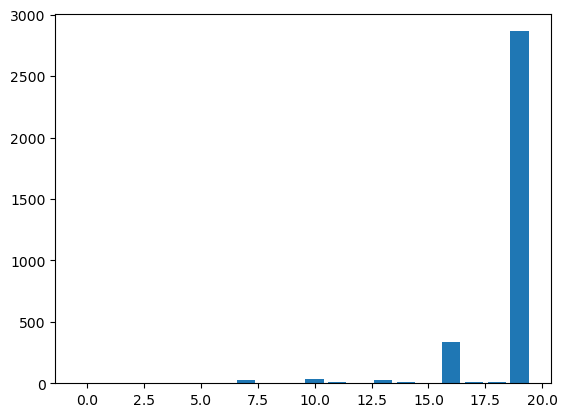

In [8]:
import matplotlib.pyplot as plt

fisher_vals = [t.item() for t in fisher]

plt.bar(np.arange(len(fisher_vals)), fisher_vals)
plt.show()